<a href="https://colab.research.google.com/github/bhadreshpsavani/TimeSerierAnalysisOnCoalConsumption/blob/main/CoalConsumptionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis of Britans Power Consumption:

We are having dataset of power consumtion demand and the sources of energy **we want to forcast requirement of coal consumption**

In [87]:
!pip install -q catboost

In [88]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

In [92]:
df = pd.read_csv('https://query.data.world/s/pija6a4rfvhbwhsmxgs6waee6tqgkg', parse_dates=[1], index_col=1)

In [93]:
df.head()

,id,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,biomass,solar
timestamp,,,,,,,,,,,
2012-01-01 00:00:01,62694,30590,50.126999,8693,7121,8568,2740,0,728,0,0.0
2012-01-01 00:05:06,62695,30490,50.039001,8650,7120,8441,2812,0,732,0,0.0
2012-01-01 00:10:01,62696,30802,50.000000,8880,7125,8427,2896,0,744,0,0.0
2012-01-01 00:15:01,62697,31180,50.028999,9111,7122,8494,2964,0,748,0,0.0
2012-01-01 00:20:01,62698,31241,50.002998,9195,7114,8449,2992,0,750,0,0.0


In [94]:
# drop unnecessary column
df.drop(columns=['id'],inplace=True)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 796453 entries, 2012-01-01 00:00:01 to 2019-08-03 20:10:34
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0    demand     796453 non-null  int64  
 1    frequency  796453 non-null  float64
 2    coal       796453 non-null  int64  
 3    nuclear    796453 non-null  int64  
 4    ccgt       796453 non-null  int64  
 5    wind       796453 non-null  int64  
 6    pumped     796453 non-null  int64  
 7    hydro      796453 non-null  int64  
 8    biomass    796453 non-null  int64  
 9    solar      796453 non-null  float64
dtypes: float64(2), int64(8)
memory usage: 66.8 MB


In [96]:
df.frequency.value_counts()

AttributeError: ignored

We are having 796453 records in our data

In [ ]:
df.describe()

From above data we can say that coal and CCGT is contributing maximum in the Energy generation

In [97]:
# remove space from column name
df.columns = [item.strip() for item in list(df.columns)]

In [98]:
df['energy_produced'] = df[['coal', 'nuclear', 'ccgt', 'wind', 'pumped', 'hydro', 'biomass', 'solar']].sum(axis=1)
df['other_energy'] = df[['nuclear', 'ccgt', 'wind', 'pumped', 'hydro', 'biomass', 'solar']].sum(axis=1)
df['energy_produced'].head(10)

 timestamp
2012-01-01 00:00:01    27850.0
2012-01-01 00:05:06    27755.0
2012-01-01 00:10:01    28072.0
2012-01-01 00:15:01    28439.0
2012-01-01 00:20:01    28500.0
2012-01-01 00:25:10    28600.0
2012-01-01 00:30:01    28515.0
2012-01-01 00:35:05    28314.0
2012-01-01 00:40:14    28424.0
2012-01-01 00:45:01    28491.0
Name: energy_produced, dtype: float64

In [99]:
df['demand'].head(10)

 timestamp
2012-01-01 00:00:01    30590
2012-01-01 00:05:06    30490
2012-01-01 00:10:01    30802
2012-01-01 00:15:01    31180
2012-01-01 00:20:01    31241
2012-01-01 00:25:10    31340
2012-01-01 00:30:01    31255
2012-01-01 00:35:05    31054
2012-01-01 00:40:14    31166
2012-01-01 00:45:01    31232
Name: demand, dtype: int64

In [100]:
df[['demand', 'energy_produced', 'other_energy', 'coal']].corr()

,demand,energy_produced,other_energy,coal
demand,1.000000,0.927885,0.482528,0.605359
energy_produced,0.927885,1.000000,0.614251,0.552917
other_energy,0.482528,0.614251,1.000000,-0.317885
coal,0.605359,0.552917,-0.317885,1.000000


### Observations:
From above analysis of correlation between columns we can say that,
* The Demand and total Produced Energy are highly correlated 
* Smiliarly there is 0.6 correlation between Demand and Coal Production 

### 1. Resampling:

In [101]:
data = df.resample('1H').sum()
data.head()

,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,biomass,solar,energy_produced,other_energy
timestamp,,,,,,,,,,,,
2012-01-01 00:00:00,372778,600.332000,107545,84685,101670,35915,1120,8971,0,0.0,339906.0,232361.0
2012-01-01 01:00:00,365904,600.249000,103154,83313,101089,35674,689,9108,0,0.0,333027.0,229873.0
2012-01-01 02:00:00,352149,600.361998,92415,83339,99320,35211,0,8977,0,0.0,319262.0,226847.0
2012-01-01 03:00:00,330551,599.778998,74389,83337,95330,35654,0,8952,0,0.0,297662.0,223273.0
2012-01-01 04:00:00,318290,599.612998,64333,84255,91842,36024,0,8940,0,0.0,285394.0,221061.0


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66525 entries, 2012-01-01 00:00:00 to 2019-08-03 20:00:00
Freq: H
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   demand           66525 non-null  int64  
 1   frequency        66525 non-null  float64
 2   coal             66525 non-null  int64  
 3   nuclear          66525 non-null  int64  
 4   ccgt             66525 non-null  int64  
 5   wind             66525 non-null  int64  
 6   pumped           66525 non-null  int64  
 7   hydro            66525 non-null  int64  
 8   biomass          66525 non-null  int64  
 9   solar            66525 non-null  float64
 10  energy_produced  66525 non-null  float64
 11  other_energy     66525 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 6.6 MB


### 2. Analysis

* Level: The average value in the series.

#### Rolling Mean:

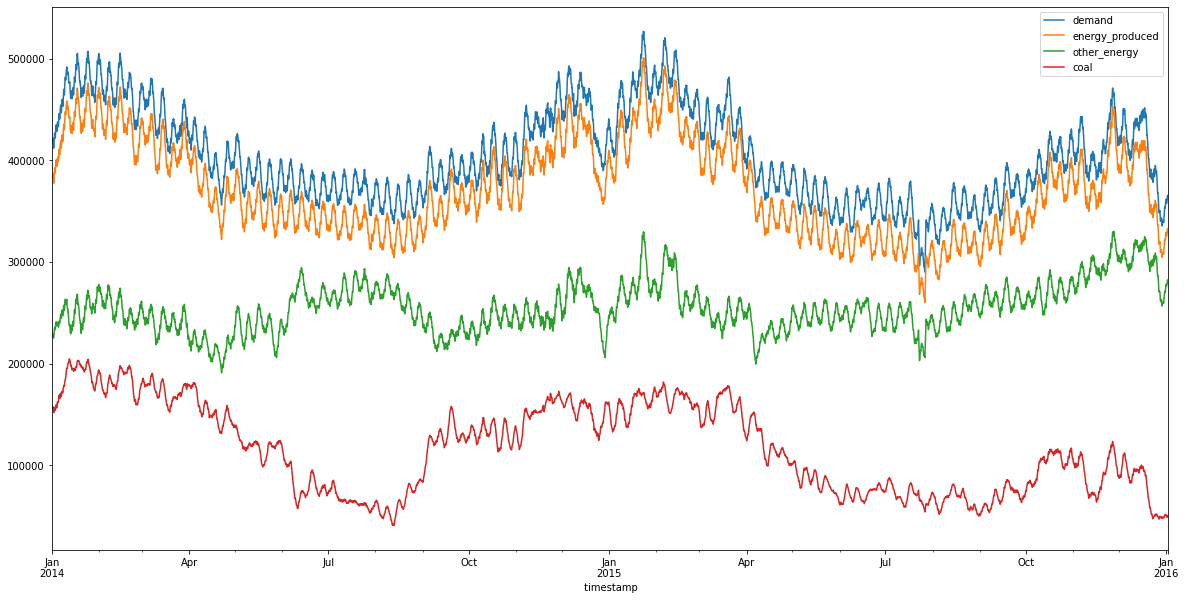

In [103]:
data[['demand', 'energy_produced', 'other_energy', 'coal']].rolling(100).mean()['2014-01-01':'2016-01-01'].plot(figsize=(20, 10))

#### 2. Trends and Seasonality

* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise: The random variation in the series.

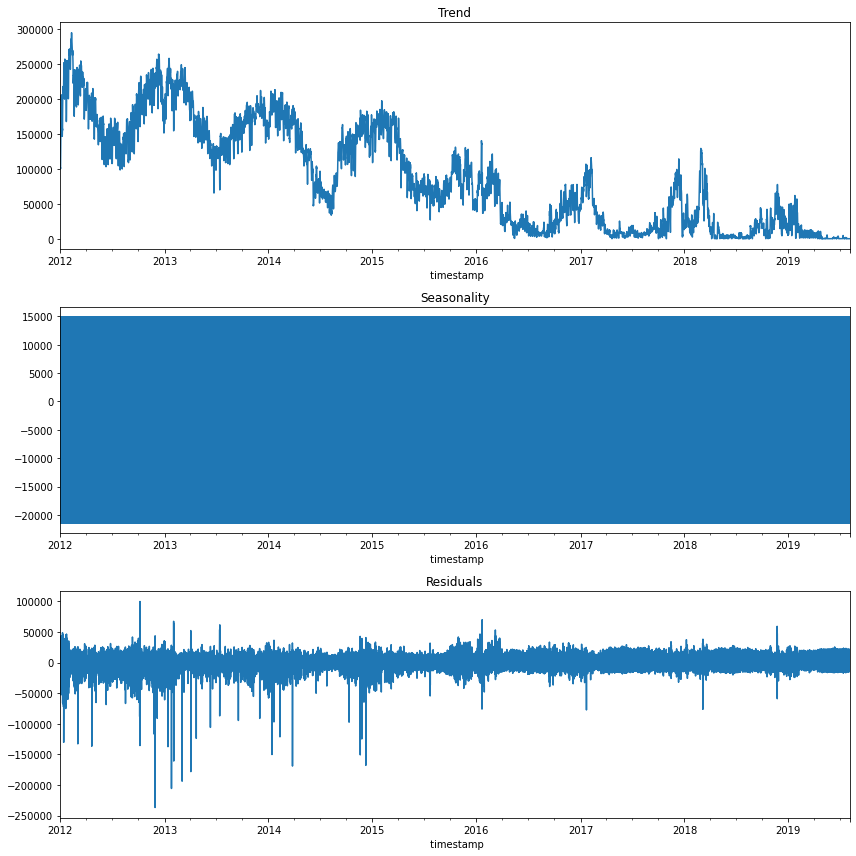

In [104]:
decomposed = seasonal_decompose(data['coal'])
plt.figure(figsize=(12, 12))
plt.subplot(311)
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

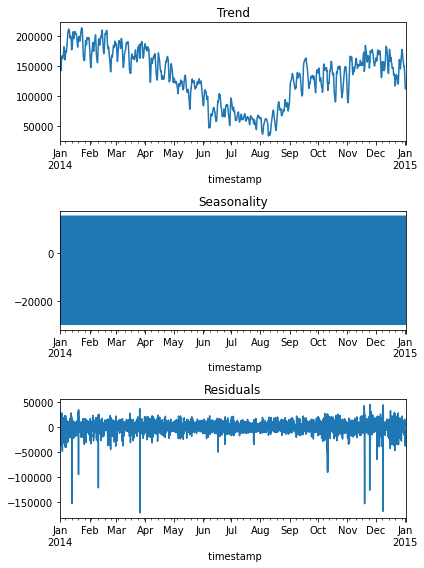

In [105]:
decomposed = seasonal_decompose(data['2014-01-01':'2015-01-01']['coal'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

From above graph we can say that trend is decaresing over time

### 3. Stationary Series:

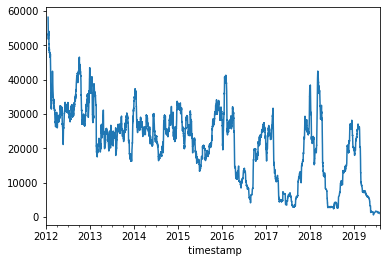

In [106]:
data['coal'].rolling(500).std().plot()

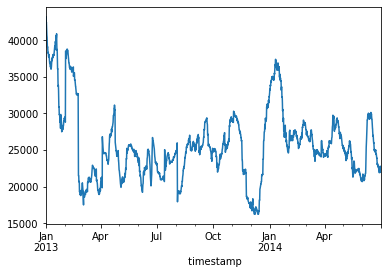

In [107]:
data['coal'].rolling(500).std()['2013-01':'2014-06'].plot()

The distribution does change, so the stochastic process is nonstationary

## Feature Extraction:

Now we will train a machine learning model which will take time as input and predict coal production.

In [108]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['coal'].shift(lag)
    data['rolling_mean'] = data['coal'].shift().rolling(rolling_mean_size).mean()

In [109]:
make_features(data, 6 , 6)

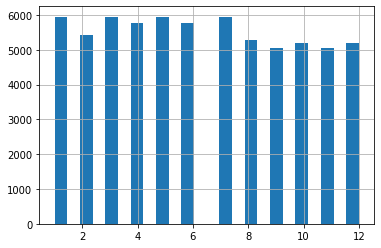

In [110]:
data.month.hist(bins=24)

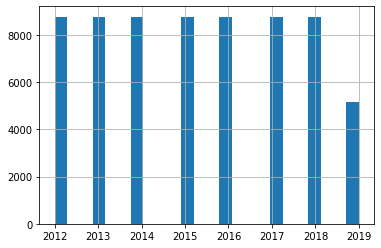

In [111]:
data.year.hist(bins=24)

In [112]:
data.head()

,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,biomass,solar,energy_produced,other_energy,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
timestamp,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,372778,600.332000,107545,84685,101670,35915,1120,8971,0,0.0,339906.0,232361.0,2012,1,1,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,365904,600.249000,103154,83313,101089,35674,689,9108,0,0.0,333027.0,229873.0,2012,1,1,6,1,107545.0,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 02:00:00,352149,600.361998,92415,83339,99320,35211,0,8977,0,0.0,319262.0,226847.0,2012,1,1,6,2,103154.0,107545.0,NaN,NaN,NaN,NaN,NaN
2012-01-01 03:00:00,330551,599.778998,74389,83337,95330,35654,0,8952,0,0.0,297662.0,223273.0,2012,1,1,6,3,92415.0,103154.0,107545.0,NaN,NaN,NaN,NaN
2012-01-01 04:00:00,318290,599.612998,64333,84255,91842,36024,0,8940,0,0.0,285394.0,221061.0,2012,1,1,6,4,74389.0,92415.0,103154.0,107545.0,NaN,NaN,NaN


In [113]:
print("Before",len(data))
data = data.dropna()
print("After",len(data))

Before 66525
After 66519


In [114]:
features = data.drop(columns=['coal', 'energy_produced', 'nuclear', 'ccgt', 'wind', 'pumped', 'hydro', 'biomass', 'solar'])
target = data['coal']

In [115]:
full_train_X, test_X, full_train_y, test_y = train_test_split(features, target, shuffle=False, test_size=0.1)
train_X, valid_X, train_y, valid_y = train_test_split(full_train_X, full_train_y, shuffle=False, test_size=0.15)
print("Trainset Size", len(train_X), "Validation set Size", len(valid_X), "Test Size", len(test_X))

Trainset Size 50886 Validation set Size 8981 Test Size 6652


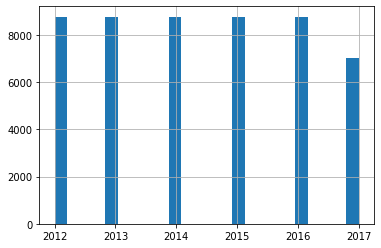

In [116]:
train_X.year.hist(bins=24)

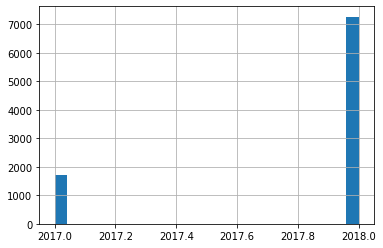

In [117]:
valid_X.year.hist(bins=24)

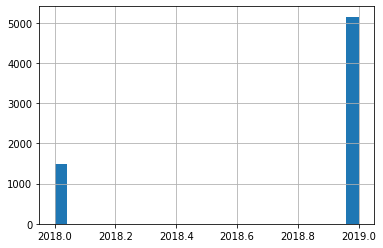

In [118]:
test_X.year.hist(bins=24)

### Create Baseline Model

In [119]:
# using mean
pred_base = np.ones(test_y.shape)*full_train_y.mean()
np.sqrt(mean_squared_error(pred_base, test_y))

88490.69921803623

In [120]:
# lets check how much error we are getting if we consider previous value as our  prediction
pred_previous = test_y.shift()
pred_previous.iloc[0]=full_train_y.iloc[-1]
np.sqrt(mean_squared_error(pred_previous, test_y))

4661.332309128096

previous value is giving better result so we will use this as our baseline score

In [121]:
def rmse(pred_valid, valid_y):
    return np.sqrt(mean_squared_error(pred_valid, valid_y))

## Model Selection:

In [124]:
def request_time(start_time, end_time):
    total_time = end_time - start_time
    total_mins = int(total_time / 60)
    total_secs = total_time - (total_mins * 60)
    return total_mins, total_secs

In [125]:
from time import time
pipelines = [('LR',LinearRegression()), ('LASSO', Lasso()), ('EN', ElasticNet()),
             ('KNN', KNeighborsRegressor()), ('RandomForest', RandomForestRegressor()) ,
             ('LGBMReg', LGBMRegressor(num_leaves=31)), ('GBM', GradientBoostingRegressor()),
             ('CatBoost', CatBoostRegressor(loss_function='RMSE', verbose=100))]
print("Model : Score (time)")
for name, model in pipelines:
    start_time = time()
    model.fit(train_X, train_y)
    pred_valid = model.predict(valid_X)
    score = rmse(pred_valid, valid_y)
    end_time = time()
    mins, secs = request_time(start_time, end_time)
    msg = "%s: %f (time %f mins %f secs)" % (name, score, mins, secs)
    print(msg)

LR: 5984.411649 time taken 0.000000 mins 0.028265 secs
LASSO: 5985.302666 time taken 0.000000 mins 1.152963 secs
EN: 5481.492966 time taken 0.000000 mins 1.163302 secs
KNN: 6180.167542 time taken 0.000000 mins 0.398094 secs
RandomForest: 5570.641226 time taken 1.000000 mins 13.659478 secs
LGBMReg: 4316.610102 time taken 0.000000 mins 0.852025 secs
GBM: 5181.896152 time taken 0.000000 mins 24.147020 secs
Learning rate set to 0.078555
0:	learn: 68691.8480872	total: 63.5ms	remaining: 1m 3s
100:	learn: 5794.0205848	total: 1.26s	remaining: 11.2s
200:	learn: 4833.4902784	total: 2.48s	remaining: 9.85s
300:	learn: 4382.0807687	total: 3.68s	remaining: 8.55s
400:	learn: 4084.3268430	total: 4.92s	remaining: 7.36s
500:	learn: 3873.8663967	total: 6.14s	remaining: 6.11s
600:	learn: 3711.1305372	total: 7.35s	remaining: 4.88s
700:	learn: 3576.8044260	total: 8.58s	remaining: 3.66s
800:	learn: 3469.6468338	total: 9.81s	remaining: 2.44s
900:	learn: 3372.6497147	total: 11s	remaining: 1.21s
999:	learn: 329

**CatBoost Regressor Model is giving best results**

## Hyperparameter Selection:

Best Hyperparameter is 100 estimator and 10 max depth

## Model Training:

In [127]:
cat_boost_regressor = CatBoostRegressor(loss_function='RMSE', verbose=100)
cat_boost_regressor.fit(full_train_X, full_train_y)

Learning rate set to 0.080861
0:	learn: 70236.9993957	total: 26.1ms	remaining: 26.1s
100:	learn: 5611.1643764	total: 1.4s	remaining: 12.4s
200:	learn: 4672.7974023	total: 2.76s	remaining: 11s
300:	learn: 4242.6968370	total: 4.13s	remaining: 9.59s
400:	learn: 3973.1365264	total: 5.49s	remaining: 8.21s
500:	learn: 3782.8250192	total: 6.87s	remaining: 6.84s
600:	learn: 3631.5545732	total: 8.29s	remaining: 5.5s
700:	learn: 3510.8748983	total: 9.66s	remaining: 4.12s
800:	learn: 3409.4996160	total: 11.1s	remaining: 2.75s
900:	learn: 3319.2373607	total: 12.4s	remaining: 1.36s
999:	learn: 3240.0936061	total: 13.8s	remaining: 0us


In [128]:
pred_test = cat_boost_regressor.predict(test_X)

In [131]:
test_X['pred'] = pred_test
test_X['target'] = test_y
rmse(pred_test, test_y)

2978.378542479762

In [132]:
test_X.head(10)[['pred', 'target']]

,pred,target
timestamp,,
2018-10-30 17:00:00,75825.557791,79121
2018-10-30 18:00:00,80713.970563,79526
2018-10-30 19:00:00,76227.014507,81056
2018-10-30 20:00:00,68701.085822,65588
2018-10-30 21:00:00,48098.750306,35245
2018-10-30 22:00:00,23113.580106,17976
2018-10-30 23:00:00,10404.307330,6137
2018-10-31 00:00:00,7033.890229,4140
2018-10-31 01:00:00,5143.807052,5196
